# Deux conteneurs
## Scénario réaliste
### Description
Le but de cette expérience est de comprendre pourquoi le mécanisme est meilleure que la `soft` limite.
Pour cela, nous étudierons deux conteneurs exécutant `sysbench` dans un scénario bien défini.

Ce scénario peut-être découpé en 5 parties :

1. Le conteneur A et B ne seront pas limités dans le nombre de transaction qu'ils envoient à leurs bases de données.

2. Le conteneur A n'enverra plus que 200 transactions par seconde à sa base de données tandis que le conteneur B continuera d'en envoyer sans limite.

3. Le conteneur A verra son nombre de transactions envoyées illimitées. Le conteneur B continue lui aussi à être illimité.

4. Le conteneur A et B seront limités à 200 transactions par seconde.

5. Le conteneur B enverra des transactions sans limite tandis que le conteneur A stagnera à 200 transactions par seconde.

6. A s'arrêtera complètement tandis que B continue de gérer beaucoup de requêtes.

Chacune de ces parties durent 180 secondes donc le scénario se déroule en 900 secondes.

Ce scénario peut être vu comme la simulation de plusieurs serveurs webs faisant face à des pics d'activité entrecoupés de période d'inactivité.

L'exécution de ce scénario avec un seul conteneur et sans limiter le nombre d'événément a permis d'obtenir un nombre d'événément moyen d'environ 800. Le chiffre de 200 a donc été décidé à partir de cette valeur (soit 25% du nombre de transactions illimitées).

#### Modification de sysbench
Le benchmark `sysbench` a été modifié afin de changer le taux de transactions à réaliser à des moments spécifiques dans le temps.
Ainsi, le scénario présenté correspond à une exécution de `sysbench` dont le taux de transactions à réaliser change toutes les 180 secondes.

#### Modification du noyau pour notre mécanisme
Pour implémenter notre mécanisme, nous avons modifié le noyau Linux et notamment la fonction `mem_cgroup_soft_limit_reclaim`.

### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle disposant de 4 coeurs virtuels et 3GB de mémoire.

Chaque conteneur dispose de 2 coeurs virtuels. Ils sont lancés avec des `soft` limites fixées à 1800MB et 1000MB.

Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

### Conditions de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Chaque conteneur manipule une base de données de 4GB.

Avant chaque expérience une sauvegarde de la base de données est effectuée afin de ramener celle-ci de force en mémoire et donc de gonfler la mémoire du conteneur.
Cette sauvegarde ramenera les données dans le cache fichier du noyau. Ainsi pour accèder à ces données `mysql` n'aura qu'à faire une copie de celles-ci depuis le cache fichier vers son tampon mémoire plutôt que ramener celles-ci depuis le disque.
Cette sauvegarde émule en quelque sorte le fait que `mysql` s'exécute depuis longtemps et à ramener toute la base de données dans sa mémoire.

Le script permettant de lancer plusieurs conteneurs en même temps et d'obtenir des statistiques sur ceux-ci est trouvable en annexe.

### Résultats obtenus
Étudions d'abord le nombre d'appels effectués à la fonction `mem_cgroup_soft_limit_reclaim` au cours du scénario pour la `soft` limite et notre mécanisme :

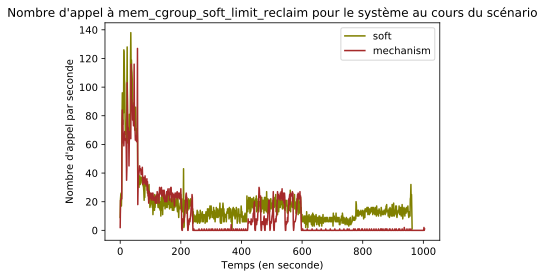

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


FILES = {'soft': {'file': 'pair_soft_limit/trace_extraction_5.dat.trace.time.csv', 'color': 'olive'}, 'mechanism': {'file':  'pair_mechanism_2/trace_extraction_5.dat.trace.time.csv', 'color': 'brown'}}

fig, calls_ax = plt.subplots()

for key in FILES:
    df = pd.read_csv(FILES[key]['file'], ';')
    values = df.values
        
    calls_ax.plot(values.take(0, axis = 1), values.take(2, axis = 1), label = key, color = FILES[key]['color'])

calls_ax.legend()
calls_ax.set_ylabel('Nombre d\'appel par seconde')
calls_ax.set_xlabel('Temps (en seconde)')
calls_ax.set_title('Nombre d\'appel à mem_cgroup_soft_limit_reclaim pour le système au cours du scénario')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Il faut noter que le graphique s'étend sur moins de 1080 secondes car à la fin de la dernière partie la fonction `mem_cgrou_soft_limit_reclaim` n'est plus appelée.
Néanmoins ce graphique s'étend sur plus de 900 secondes car l'enregistrement des appels à `mem_cgroup_soft_limit_reclaim` commence un peu avant l'exécution d'un scénario.
Cette courbe ne comprend pas de moyenne ni d'écart-type car ces valeurs n'auraient pas vraiment de sens puisque le comportement étudié est celui du noyau et est donc fortement volatile.
Les chiffres dépeints le sont donc pour la sixième exécution du scénario (sur dix exécutions en tout).
Les différentes phases d'exécution du scénario sont reconnaissables à partir de 60 secondes.

On peut voir que lorsqu'il n'y a qu'un seul conteneur qui reçoit un pic de requête ou bien que les deux conteneurs présentent peu d'activité la fonction est moins appelée avec notre mécanisme.
Quand les deux conteneurs sont actifs le nombre d'appel est équivalent à celui de la `soft` limite.

Regardons maintenant le temps total passé dans cette fonction ainsi que le nombre d'appels total pendant le scénario :

In [2]:
import pandas as pd
from IPython.display import HTML, display


TABLE = """
<table>
	<tr>
		<th>Caractéristiques \ Mécanisme utilisé </th>
		<th colspan="2">Soft limit</th>
		<th colspan="2">Notre mécanisme</th>
	</tr>
	<tr>
		<th></th>
		<th>Moyenne<br></th>
		<th>Écart-type</th>
		<th>Moyenne</th>
		<th>Écart-type</th>
	</tr>
	<tr>
		<td>Temps (en seconde)<br></td>
		<td>%f</td>
		<td>%f</td>
		<td>%f</td>
		<td>%f</td>
	</tr>
	<tr>
		<td>Nombre d'appels<br></td>
		<td>%f</td>
		<td>%f</td>
		<td>%f</td>
		<td>%f</td>
	</tr>
</table>
"""

FILES = {'soft': 'pair_soft_limit/pair_soft_limit.trace.csv', 'mechanism': 'pair_mechanism_2/pair_mechanism_2.trace.csv'}

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'time': {}, 'calls': {}}
    
for key in FILES:
    # Get data from CSV file.
    df = pd.read_csv(FILES[key], ';')
    values = df.values

    # Computing mean and standard deviation.
    # values is a numpy.ndarray i.e an array of tuples.
    # mean() and std() take an axis as argument and return a tuple.
    # [1] permits to obtain second member of tuple.
    # The queries are the first csv field (+ 1 because of the run column).
    dictionnary[key]['time']['mean'] = values.mean(0)[1]
    dictionnary[key]['time']['std'] = values.std(0)[1]

    dictionnary[key]['calls']['mean'] = values.mean(0)[2]
    dictionnary[key]['calls']['std'] = values.std(0)[2]

display(HTML(TABLE % (dictionnary['soft']['time']['mean'], dictionnary['soft']['time']['std'], dictionnary['mechanism']['time']['mean'], dictionnary['mechanism']['time']['std'], dictionnary['soft']['calls']['mean'], dictionnary['soft']['calls']['std'], dictionnary['mechanism']['calls']['mean'], dictionnary['mechanism']['calls']['std'])))

Les nombres contenus dans le tableau correspondent aux moyennes et écarts-types des 10 exécutions.
Avec notre mécanisme, le nombre d'appel est réduit mais le temps passé dans la fonction est supérieur à la `soft` limite.

Interessons-nous au temps total passé en mode système :

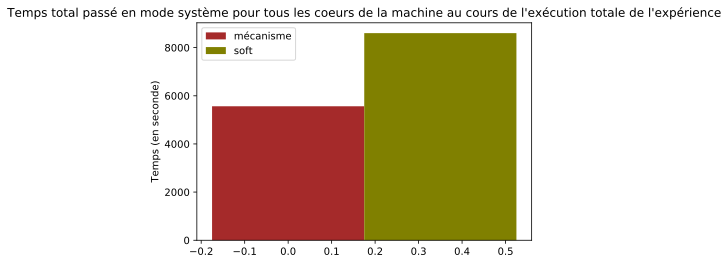

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


FILES = {'soft': {'file': 'pair_soft_limit/pair_soft_limit.py_proc_stat.csv', 'color' : 'olive'}, 'mécanisme': {'file': 'pair_mechanism_2/pair_mechanism.py_proc_stat.csv', 'color': 'brown'}}
WIDTH = .35

sorted_keys = sorted(FILES.keys())

fig, time_ax = plt.subplots()
x_pos = 0

for key in sorted_keys:
        # Get data from CSV file.
        df = pd.read_csv(FILES[key]['file'], ';')
        values = df.values
    
        time_ax.bar(x_pos, values.take(1, axis = 1), WIDTH , align = 'center', capsize = 10, color = FILES[key]['color'])
        x_pos += WIDTH

time_ax.legend(sorted_keys)
time_ax.set_ylabel('Temps (en seconde)')
time_ax.set_title("Temps total passé en mode système pour tous les coeurs de la machine au cours de l'exécution totale de l'expérience")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Le temps indiqué sur le graphique ci-dessus est le temps total passé en système pour toutes l'expérience (temps de démarrage de la machine, du lancement du script, de préparation de l'expérience et exécution des 10 expériences).
En effet, ces données ont été récupérées depuis le fichier `/proc/stat`.
Ce temps est plus grand que la durée d'exécution du système depuis le démarrage de la machine car il correspond à la somme de ce temps sur les 4 coeurs de la machine.

On peut voir que notre mécanisme permet d'économiser environ un tiers du temps passé en mode système par rapport à la `soft` limite.

### Conclusion
Notre mécanisme permet aux conteneurs de gagner en performance car il leur donne la mémoire dont ils souhaitent disposer tout en réduisant le temps passé en mode système.